In [4]:
import pandas as pd
df = pd.read_csv('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/data/COMED_hourly_preprocessed.csv')
train = df.iloc[:int(0.8 * len(df))]
test = df.iloc[int(0.8 * len(df)):]

In [5]:
df

,Datetime,COMED_MW_scaled,Season_encoded,Time_of_day_encoded,Holiday_encoded
0,2011-01-01 01:00:00,-0.557143,3,3,1
1,2011-01-01 02:00:00,-0.688278,3,3,1
2,2011-01-01 03:00:00,-0.784249,3,3,1
3,2011-01-01 04:00:00,-0.883150,3,3,1
4,2011-01-01 05:00:00,-0.900366,3,3,1
...,...,...,...,...,...
66492,2018-08-02 20:00:00,1.935897,2,1,1
66493,2018-08-02 21:00:00,1.625641,2,1,1
66494,2018-08-02 22:00:00,1.441026,2,3,1
66495,2018-08-02 23:00:00,1.207326,2,3,1


In [6]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
X_train = train[['Season_encoded', 'Time_of_day_encoded', 'Holiday_encoded']]
y_train = train['COMED_MW_scaled']

X_test = test[['Season_encoded', 'Time_of_day_encoded', 'Holiday_encoded']]
y_test = test['COMED_MW_scaled']

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from tqdm import tqdm
import joblib

param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svr = SVR()

total_combinations = len(joblib.Parallel(n_jobs=-1)(
    joblib.delayed(lambda x:x)(1) for _ in tqdm(range(len(param_grid['C']) * len(param_grid['epsilon']) * len(param_grid['kernel'])), desc="Evaluating")
))

grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

svr_model = grid_search
svr_model.fit(X_train, y_train)

best_params = svr_model.best_params_

print(f"Best parameters: {best_params}")


Evaluating: 100%|██████████| 80/80 [00:00<00:00, 495.40it/s]


Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=  49.5s
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=  50.3s
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=  50.9s
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time= 1.0min
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time= 1.1min
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time= 1.2min
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time=  56.7s
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time=  57.8s
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time=  59.0s
[CV] END ..................C=0.1, epsilon=0.2, kernel=linear; total time=  38.0s
[CV] END ..................C=0.1, epsilon=0.2, kernel=linear; total time=  38.0s
[CV] END ..................C=0.1, epsilon=0.2, 

In [9]:
svr_model = SVR(C=1, epsilon=0.5, kernel='rbf')

# Fit the model on the training data
svr_model.fit(X_train, y_train)

SVR(C=1, epsilon=0.5)

In [10]:
# Make predictions
y_pred = svr_model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

Mean Squared Error: 0.3935857961576358
Mean Absolute Error: 0.47667684301612473
R2 Score: 0.3895774463105368


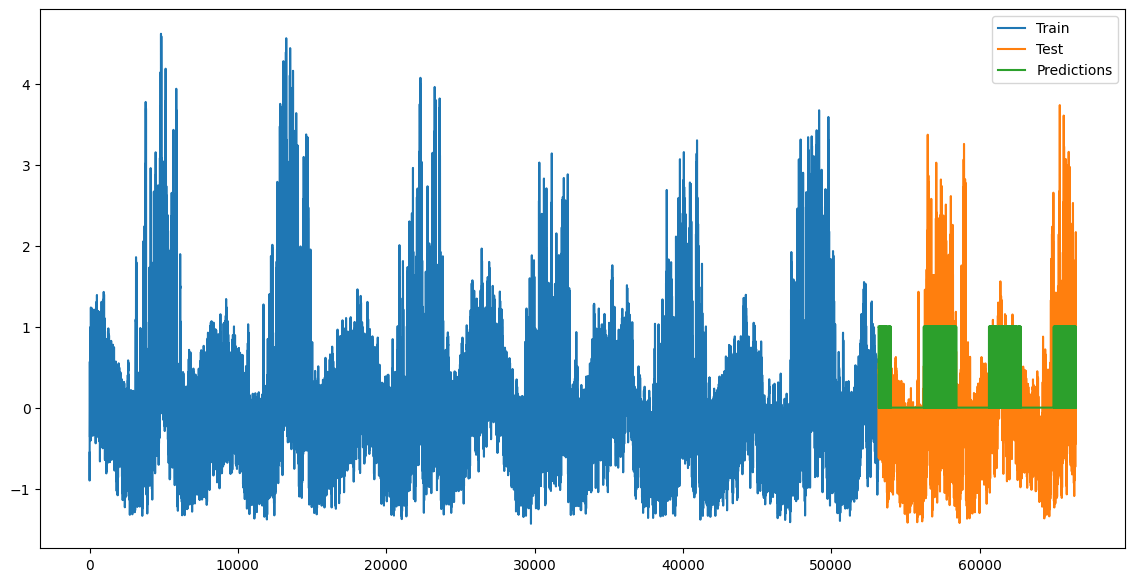

In [12]:
#plot the predictions as a continued line starting from the train data
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['COMED_MW_scaled'], label='Train')
plt.plot(test.index, test['COMED_MW_scaled'], label='Test')
plt.plot(test.index, y_pred, label='Predictions')
plt.legend()
plt.show()

In [25]:
import numpy as np
df['Predictions'] = np.nan

df.loc[df.index[int(0.8 * len(df)):], 'Predictions'] = svr_model.predict(test[['Season_encoded', 'Time_of_day_encoded', 'Holiday_encoded']])

df.to_csv('test.csv', index=False)

In [13]:
# Use cross-validation to ensure the model generalizes well to unseen data.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross Validation Mean Squared Error:", scores.mean())

Cross Validation Mean Squared Error: -0.4486690651263956


In [15]:
#save the model
import joblib
joblib.dump(svr_model, '/home/hashim/Assignments/Sem6/DataMining/DM_Proj/models/svr_model.pkl')

['/home/hashim/Assignments/Sem6/DataMining/DM_Proj/models/svr_model.pkl']

In [2]:
import pandas as pd
df = pd.read_csv('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/data/COMED_hourly_preprocessed.csv')
train = df.iloc[:int(0.8 * len(df))]
test = df.iloc[int(0.8 * len(df)):]

In [16]:
#load the model
svr_model = joblib.load('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/models/svr_model.pkl')

In [9]:
#make a csv file that saves the original dataframe and the predictions. The predictions can be NaN for the data that was not used for testing
df['Predictions'] = svr_model.predict(df[['Season_encoded', 'Time_of_day_encoded', 'Holiday_encoded']])
df.to_csv('/home/hashim/Assignments/Sem6/DataMining/DM_Proj/data/COMED_hourly_preprocessed_with_predictions.csv', index=False)